# Classificação de renda

---

- [Enunciado](#enunciado)
- [Setup](#setup)
  - [Importando pacotes e dados](#importando-pacotes-e-dados)
  - [Criando dicionário de cores](#criando-dicionário-de-cores)
  - [Declarações de funções](#declarações-de-funções)
- [EDA](#eda)
  - [Overview dos dados](#overview-dos-dados)
  - [Examinando distribuições](#examinando-distribuições)
  - [Codificando dados](#codificando-dados)
  - [Calculando correlação](#calculando-correlação)
    - [Criando DataFrame de correlação](#criando-dataframe-de-correlação)
    - [Matriz de correlação](#matriz-de-correlação)
    - [Correlação com `education` e `occupation`](#correlação-com-education-e-occupation)
  - [Separando features e alvo](#separando-features-e-alvo)
- [Modelagem](#modelagem)
  - [Criando Pipeline](#criando-pipeline)
  - [DecisionTreeClassifier](#decisiontreeclassifier)
  - [RandomForestClassifier](#randomforestclassifier)
  - [Avaliação com `classification_report`](#avaliação-com-classification_report)
    - [Relatório de classificação do estimador DecisionTreeClassifier](#relatório-de-classificação-do-estimador-decisiontreeclassifier)
    - [Relatório de classificação do estimador RandomForestClassifier](#relatório-de-classificação-do-estimador-randomforestclassifier)
  - [Feature Importance](#feature-importance)
- [Validação Cruzada](#validação-cruzada)
  - [Hold-out](#hold-out)
  - [K-fold](#k-fold)
  - [Stratified k-fold](#stratified-k-fold)
- [Redução de dimensionalidade](#redução-de-dimensionalidade)
  - [Discutindo performance](#discutindo-performance)
  - [Adicionando PCA à Pipeline](#adicionando-pca-à-pipeline)
    - [DecisionTreeClassifier com PCA](#decisiontreeclassifier-com-pca)
    - [RandomForestClassifier com PCA](#randomforestclassifier-com-pca)
  - [Avaliação do PCA com `classification_report`](#avaliação-do-pca-com-classification_report)
- [Salvando modelos](#salvando-modelos)

---

## Enunciado

O conjunto de dados "Adult" (Census Income) reúne informações do censo dos EUA de 1994, com 48.842 registros e 14 atributos demográficos e socioeconômicos. Seu objetivo é construir um modelo de classificação binária para prever se a renda atual de um indivíduo excede USD$50.000$.

**Atributos:**

1. Idade (`age`).
2. Horas trabalhadas por semana (`hours-per-week`).
3. Ganho de capital (`capital-gain`).
4. Perda de capital (`capital-loss`).
5. Peso da amostra (`fnlwgt`).
6. Classe de trabalho (`workclass`).
7. Nível de escolaridade (`education`).
8. Estado civil (`marital-status`).
9. Ocupação (`occupation`).
10. Grau de parentesco (`relationship`).
11. Raça (`race`).
12. Sexo (`sex`).
13. País de origem (`native-country`).

Treine dois modelos de classificação, uma _Árvore de Decisão_ e um modelo _Random Forest_. Avalie cada modelo usando Acurácia, Precisão, Recall, e F1-Score. Após a avaliação, gere uma matriz de confusão e um gráfico de importância de atributos.

Como tarefas opcionais:

- **_EDA_**: Examine as distribuições de idade, horas, ganho, etc.. Investigue correlações, e a influência de `education` e `occupation`.

- **_Validação cruzada_**: Aplique e compare _hold-out_, _K-fold_, e _Stratified K-fold_. Discuta o impacto na variância e no viés dos modelos.

- **_Redução de Dimensionalidade_**: Codifique e normalize variáveis. Aplique _PCA_ e avalie o efeito no desempenho dos classificadores


## Setup


### Importando pacotes e dados


In [ ]:
# Importando pacotes

# Type hinting
from typing import Tuple, Dict

# Manipulação de dados
import numpy as np
import pandas as pd

# Visualização
import seaborn as sns
import matplotlib.pyplot as plt

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer


# Utilidades
import pickle
from sklearn.model_selection import train_test_split

# Métricas
from sklearn.metrics import classification_report

# Redução de dimensionalidade
from sklearn.decomposition import PCA

# Validação cruzada
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict

# Modelos de classificação
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Importando dados
df = pd.read_csv('../datasets/adult_income.csv')

In [3]:
# Criando cópia do dataset original
df_copy = df.copy(deep=True)

In [4]:
# Renomeando colunas
df_copy.columns = [i.replace('.', '_') for i in df_copy.columns]

### Criando Dicionário de cores


In [5]:
# Criando dict de pallete
sns.set_theme(style='darkgrid')
sns.set_context('notebook', font_scale=1.2)
colors = sns.color_palette('Paired', len(df_copy.columns))
color_dict = {df_copy.columns[i]: colors[i] for i in range(len(df_copy.columns))}

### Declarações de funções


In [6]:
# Função para imprimir boxplots dos dados
def dataframe_boxplots(
    df: pd.DataFrame,
    color_dict: Dict[str, Tuple[float, float, float]],
    nrows: int,
    ncols: int,
    figsize: Tuple[int, int],
) -> None:
    _, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    axes = ax.flatten()
    for i, column in enumerate(df):
        sns.boxplot(df[column], orient='h', color=color_dict[column], ax=axes[i])
        axes[i].set_title(f'Boxplot {column}')
        axes[i].tick_params(axis='x', rotation=45)

    plt.suptitle('Features boxplots')
    plt.tight_layout()
    plt.show()

In [7]:
# Função para imprimir histograma dos dados
def dataframe_histograms(
    df: pd.DataFrame,
    color_dict: Dict[str, Tuple[float, float, float]],
    nrows: int,
    ncols: int,
    figsize: Tuple[int, int],
) -> None:
    _, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    axes = ax.flatten()
    for i, column in enumerate(df):
        sns.histplot(df[column], color=color_dict[column], ax=axes[i])
        axes[i].set_title(f'Histogram {column}')
        axes[i].tick_params(axis='x', rotation=45)

    plt.suptitle('Features distributions')
    plt.tight_layout()
    plt.show()

In [8]:
# Função para imprimir visualização de correlação
def plot_correlation(
    corr_df: pd.Series, color_dict: Dict[str, Tuple[float, float, float]]
) -> None:
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=corr_df.values,
        y=corr_df.index,
        hue=corr_df.index,
        palette='Paired',
    )
    plt.title('Correlation of columns and diabetes diagnose (Outcome)', fontsize=12)
    plt.xlabel('Pearson Correlation')
    plt.ylabel('Columns')
    plt.tight_layout()
    plt.show()

In [9]:
# Função para codificação por frequência
def frequency_encoding(X: pd.DataFrame) -> pd.DataFrame:
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)
    for col in X.columns:
        freq = X[col].value_counts(normalize=True).to_dict()
        X[col] = X[col].map(freq)
    return X

## EDA


### Overview dos dados

Aqui foram buscados dados faltantes, foram encontrados não como `NaN`s mas sim como entradas nas features de tipo `object` como `?`.

Além disso, foram contados todos of valores únicos de cada feature e seus números de ocorrência.


In [10]:
# Visualizando head do dataset
df_copy.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [11]:
# Obtendo informações sobre o dataset
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [12]:
# Descrevendo dados
df_copy.describe().round(2)

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32561.00,32561.00,32561.00,32561.00,32561.00,32561.00
mean,38.58,189778.37,10.08,1077.65,87.30,40.44
std,13.64,105549.98,2.57,7385.29,402.96,12.35
min,17.00,12285.00,1.00,0.00,0.00,1.00
25%,28.00,117827.00,9.00,0.00,0.00,40.00
50%,37.00,178356.00,10.00,0.00,0.00,40.00
75%,48.00,237051.00,12.00,0.00,0.00,45.00
max,90.00,1484705.00,16.00,99999.00,4356.00,99.00


In [13]:
# Soma total de dados nulos por feature
df_copy.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64

In [14]:
# Separando features em numéricas e categóricas
cat_features = df_copy.select_dtypes(include=['object']).columns.tolist()

num_features = df_copy.select_dtypes(exclude=['object']).columns.tolist()

In [15]:
# Visualizando valores únicos por feature
for cat_feature in cat_features:
    unique_value_counts = df_copy[cat_feature].value_counts().to_dict()

    print(
        '-' * 50,
        f'Feature "{cat_feature}": {len(unique_value_counts)} valores únicos',
        sep='\n',
    )

    for value, count in unique_value_counts.items():
        print(f'{value} : {count}')

--------------------------------------------------
Feature "workclass": 9 valores únicos
Private : 22696
Self-emp-not-inc : 2541
Local-gov : 2093
? : 1836
State-gov : 1298
Self-emp-inc : 1116
Federal-gov : 960
Without-pay : 14
Never-worked : 7
--------------------------------------------------
Feature "education": 16 valores únicos
HS-grad : 10501
Some-college : 7291
Bachelors : 5355
Masters : 1723
Assoc-voc : 1382
11th : 1175
Assoc-acdm : 1067
10th : 933
7th-8th : 646
Prof-school : 576
9th : 514
12th : 433
Doctorate : 413
5th-6th : 333
1st-4th : 168
Preschool : 51
--------------------------------------------------
Feature "marital_status": 7 valores únicos
Married-civ-spouse : 14976
Never-married : 10683
Divorced : 4443
Separated : 1025
Widowed : 993
Married-spouse-absent : 418
Married-AF-spouse : 23
--------------------------------------------------
Feature "occupation": 15 valores únicos
Prof-specialty : 4140
Craft-repair : 4099
Exec-managerial : 4066
Adm-clerical : 3770
Sales : 365

In [16]:
# Numero de ocorrências de "?" nos dados
df_copy[cat_features].map(lambda x: str(x).count('?')).sum()

workclass         1836
education            0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
native_country     583
income               0
dtype: int64

### Examinando distribuições

Ao analisar ambos os plot (histograma e boxplot), é possível perceber que as medidas são assimétricas (em especial `capital_gain` e `capital_loss`), e que grande parte das features possui grande quantidade de outliers.


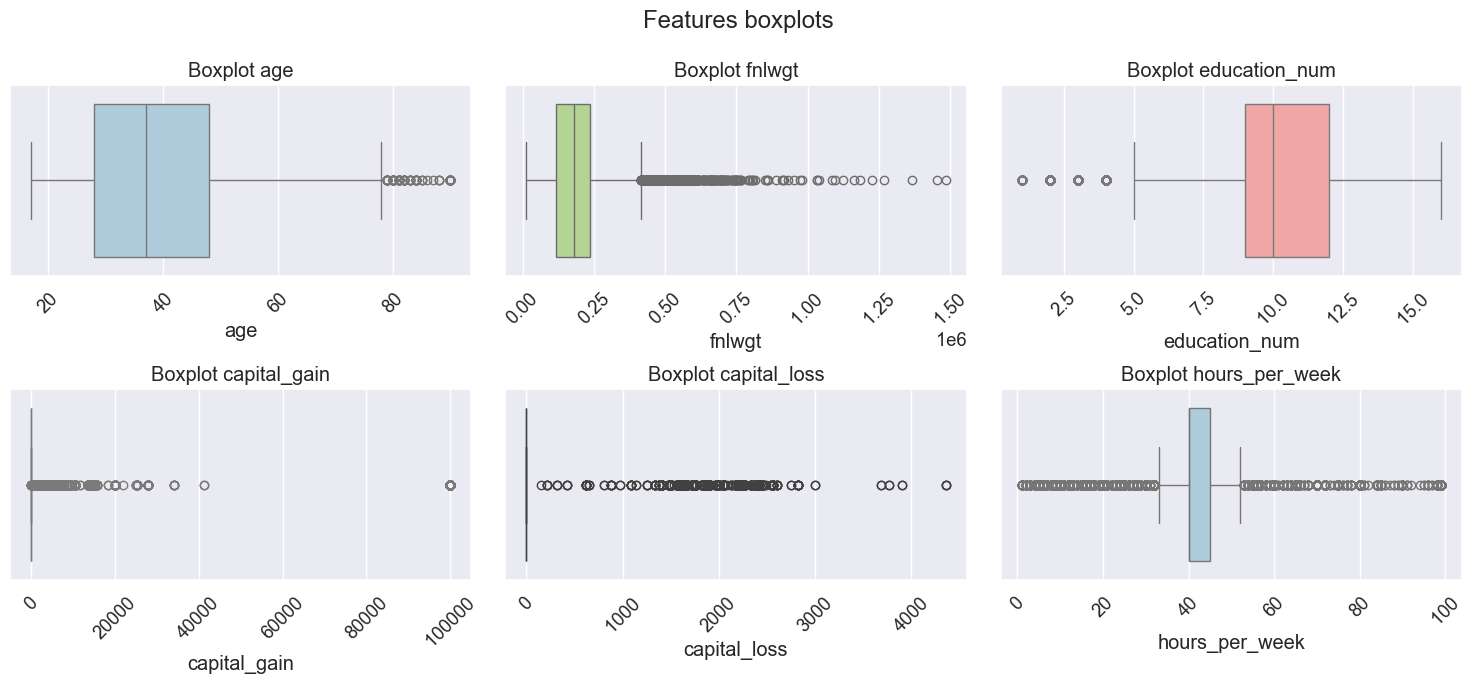

In [17]:
# Visualizando boxplot para colunas numéricas
dataframe_boxplots(df_copy[num_features], color_dict, nrows=2, ncols=3, figsize=(15, 7))

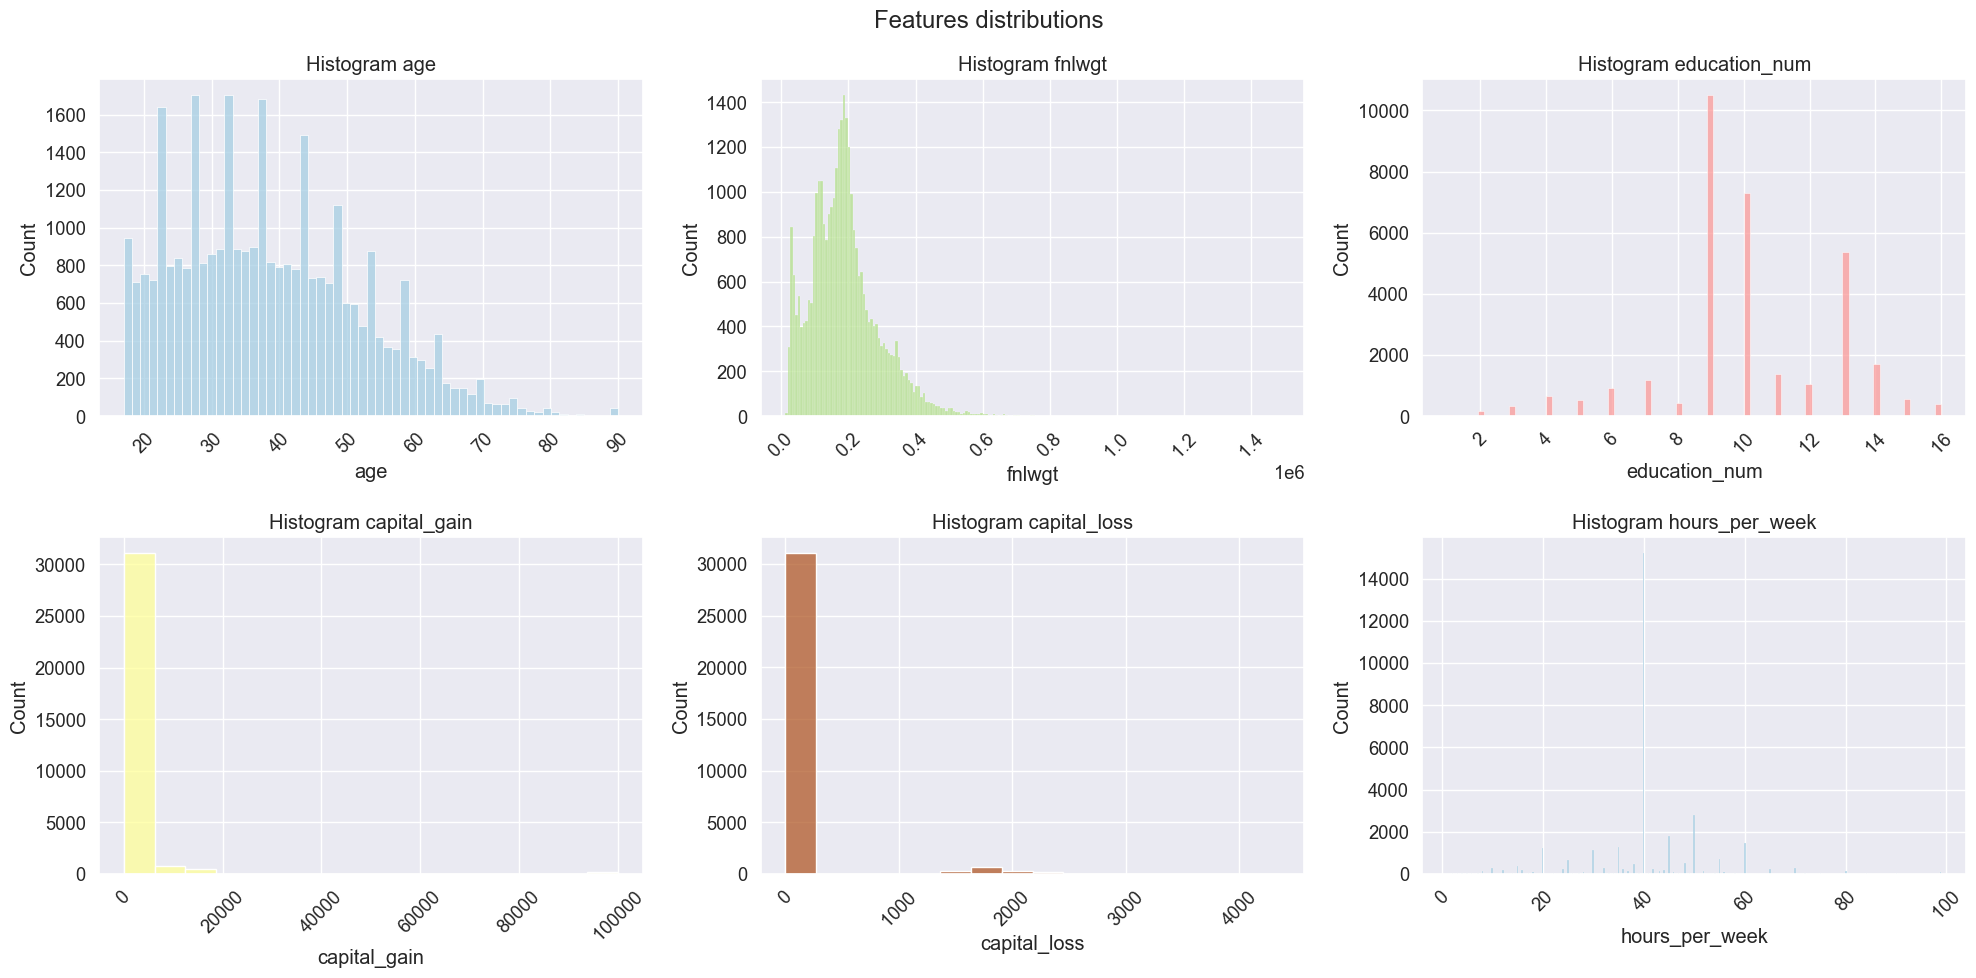

In [18]:
# Visualizando histogramas de colunas numéricas
dataframe_histograms(
    df_copy[num_features], color_dict, nrows=2, ncols=3, figsize=(20, 10)
)

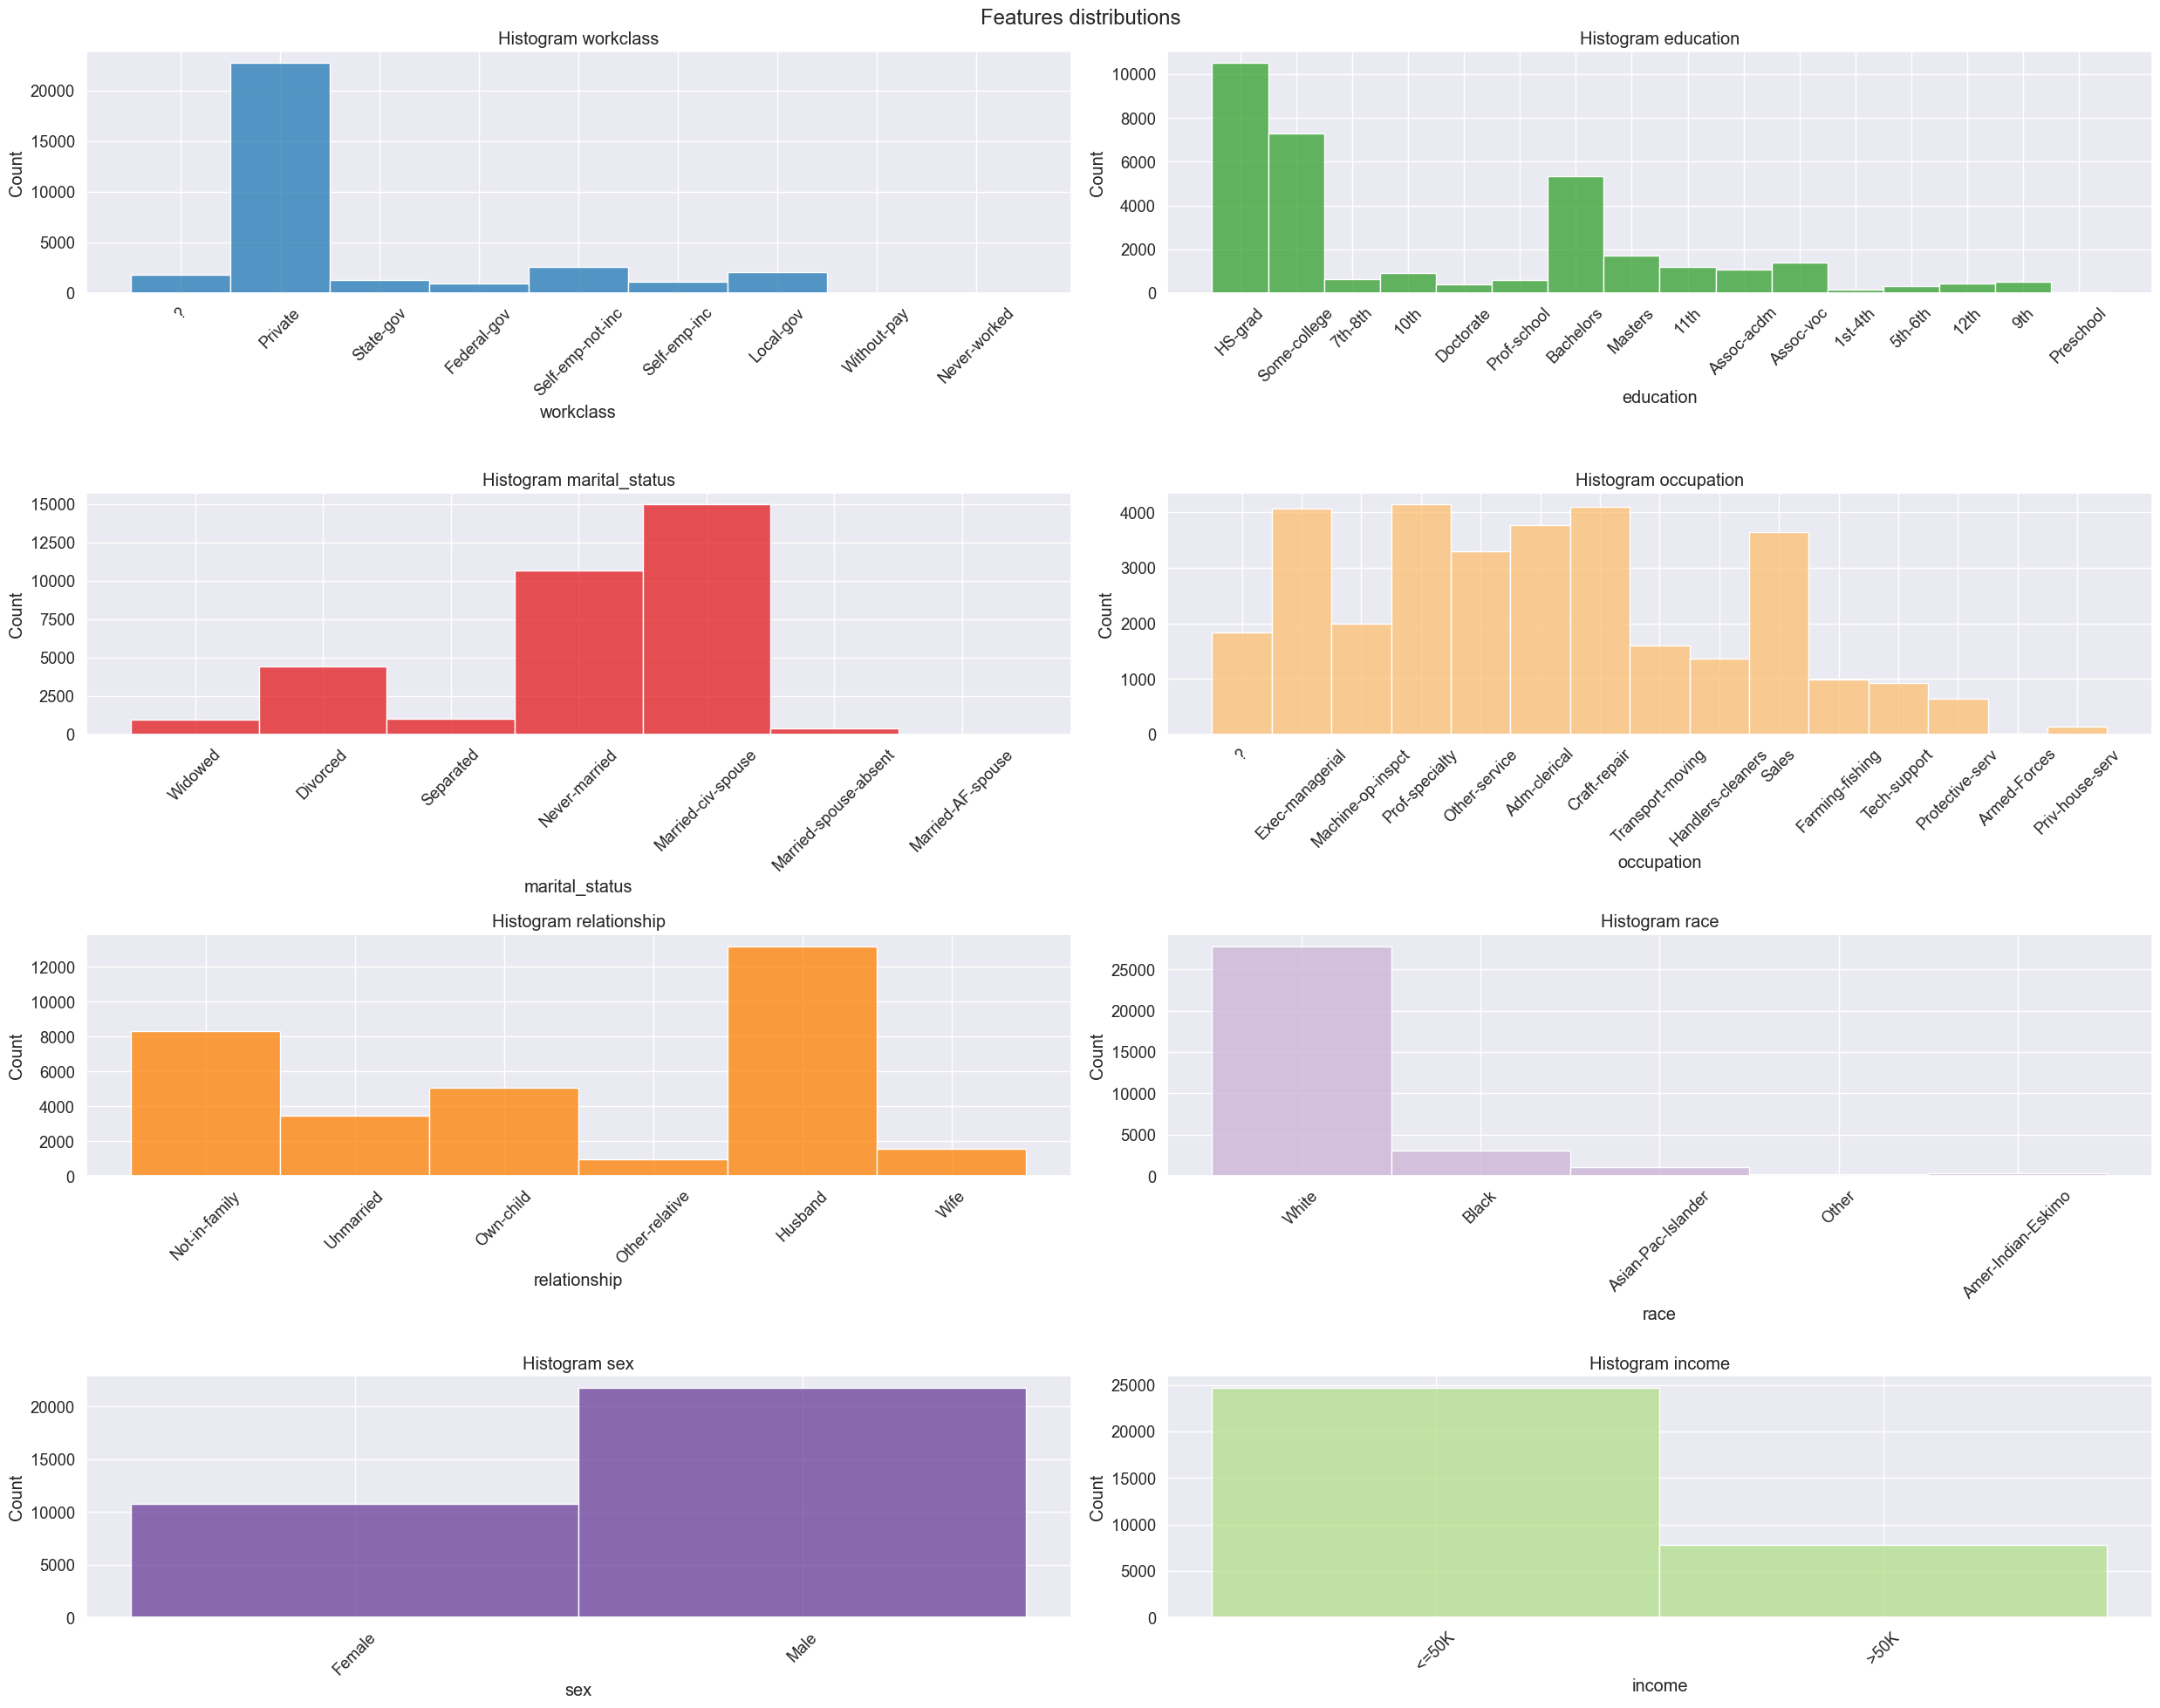

In [19]:
# Visualizando histogramas de colunas categóricas
dataframe_histograms(
    df_copy[cat_features].drop('native_country', axis=1),
    color_dict,
    nrows=4,
    ncols=2,
    figsize=(25, 20),
)

### Codificando dados

Foi criado um dataset codificado de modo a possibilitar o cálculo de correlação (feito na próxima seção).

    Obs.: A feature `education` foi retirada pois já existia sua versão codificada.


In [20]:
# Criando nova cópia
encoded_df = df_copy.copy(deep=True)

In [21]:
# Codificando dados

# Codificando baixa cardinalidade com OneHotEncoding
low_card_cols = ['sex', 'income']
encoded_df = pd.get_dummies(encoded_df, columns=low_card_cols, drop_first=True)

# Codificando cardinalidade média com TargetEncoding
medium_card_cols = ['race', 'relationship', 'marital_status', 'occupation', 'workclass']
for col in medium_card_cols:
    target_mean = encoded_df.groupby(col)['income_>50K'].mean()
    encoded_df[col + '_encoded'] = encoded_df[col].map(target_mean)

# Codificando alta cardinalidade com FrequencyEncoding
high_card_cols = ['native_country']
for col in high_card_cols:
    freq_encoding = encoded_df[col].value_counts(normalize=True).to_dict()
    encoded_df[col + '_encoded'] = encoded_df[col].map(freq_encoding)

# Removendo features sem codificação
encoded_df.drop(medium_card_cols + high_card_cols + ['education'], axis=1, inplace=True)

### Calculando correlação


#### Criando DataFrame de correlação


In [22]:
# Criando DataFrame de correlação
correlation_df = encoded_df.corr()

#### Matriz de correlação


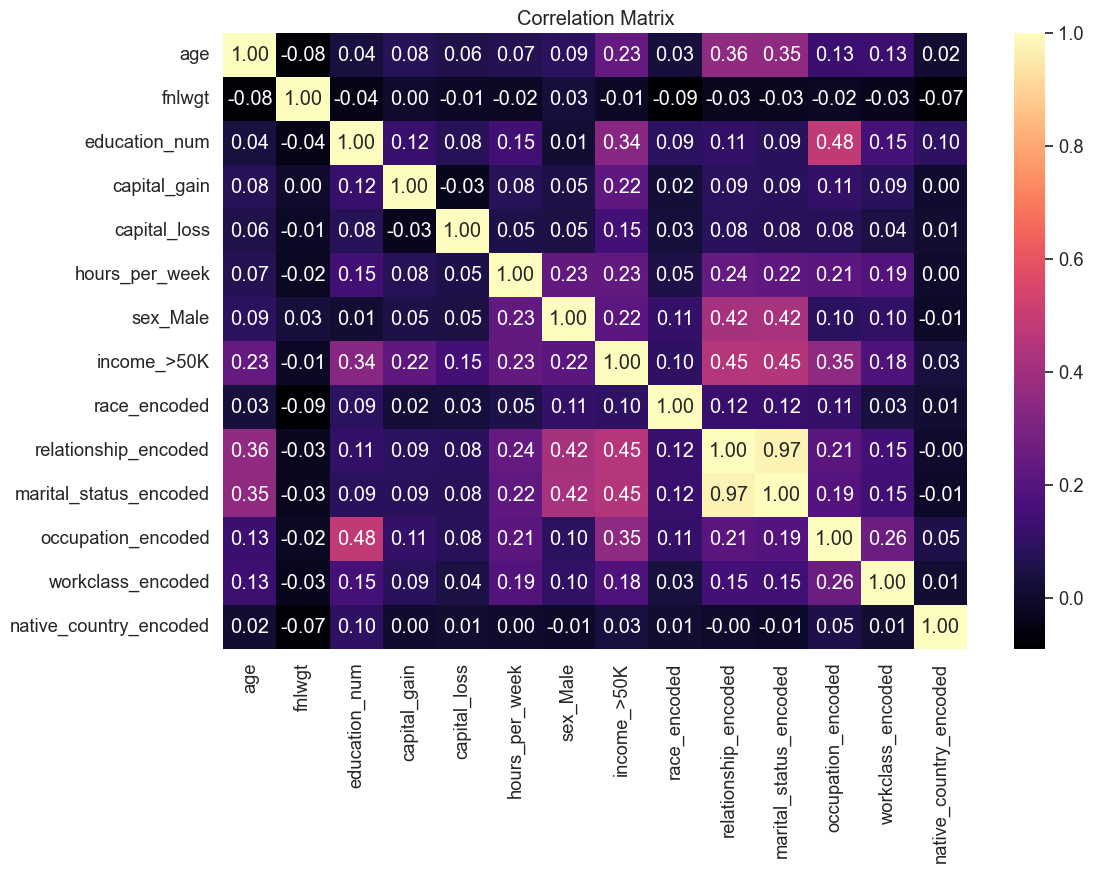

In [23]:
# Plotting the heatmap for better visualization
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_df, annot=True, cmap='magma', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

#### Correlação com `education` e `occupation`

Primeiramente foi separada a correlação das features com o alvo `income_>50K`, em seguida foram selecionadas as correlações com `education` e `ocupation`.

Ambas as features possuem alta correlação com salários maiores que $\$50.000$, com valores maiores que $0.3$.


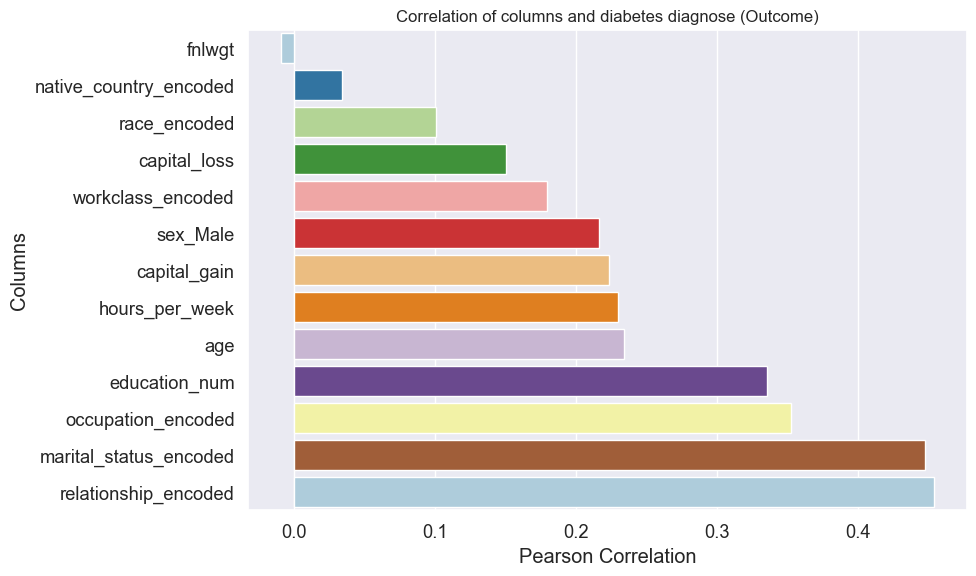

In [24]:
# Obtendo coluna de correlação
corr_income = correlation_df['income_>50K'].sort_values().drop('income_>50K')

# Criando plot
plot_correlation(corr_income, color_dict)

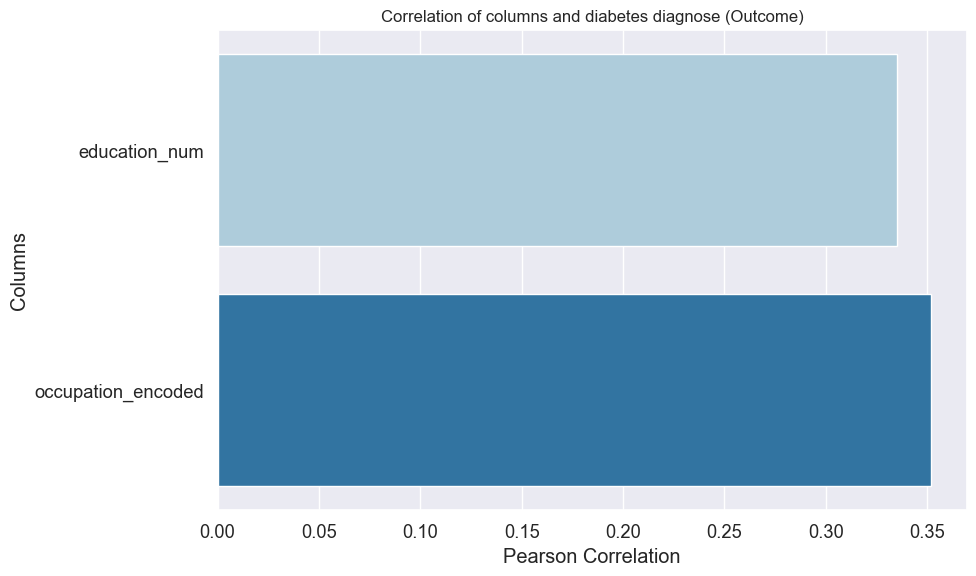

In [25]:
# Obtendo variáveis alvo
edu_occu_corr_income = corr_income[['education_num', 'occupation_encoded']]

# Visualizando correlação
plot_correlation(edu_occu_corr_income, color_dict)

### Separando features e alvo


In [26]:
# Features
X = df_copy.drop(['income', 'education'], axis=1)

# Labels
y = (df_copy['income'] == '<=50K').astype(int)

## Modelagem

A modelagem foi feita usando dois estimadores:

- `DecisionTreeClassifier`: algoritmo que constrói uma árvore de decisão, realizando divisões binárias nos atributos que melhor separam as classes com base em uma métrica como _gini_ ou _entropia_. A árvore aprende regras hierárquicas que permitem classificar novos exemplos.

- `RandomForestClassifier`: algoritmo que combina uma série de árvores de decisão treinadas com diferentes amostras dos dados para criar um modelo robusto e preciso. Cada árvore gera uma previsão independente, e o resultado final é obtido pela média das previsões individuais. Essa abordagem reduz a variância e aumenta a estabilidade.

Ambos usaram da mesma pipeline de pré-processamento, com codificações dos dados categóricos com base em suas cardinalidades, enquanto os dados numéricos são normalizados com `StandardScaler`.


### Criando Pipeline


In [27]:
# Pipeline para valores numéricos
num_pipeline = Pipeline(
    [
        ('impute', SimpleImputer()),
        ('scaler', StandardScaler()),
    ]
)

# Pipelines para valores categóricos
freq_encoder = FunctionTransformer(frequency_encoding, validate=False)

low_card_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='constant', fill_value='?')),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False)),
    ]
)

medium_card_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='constant', fill_value='?')),
        ('target_mean', TargetEncoder()),
    ]
)

high_card_pipeline = Pipeline(
    [
        ('impute', SimpleImputer(strategy='constant', fill_value='?')),
        ('target_mean', freq_encoder),
    ]
)

In [28]:
# Removendo target das colunas para codificação
low_card_cols.remove('income')

In [29]:
# Definindo transformador de pré-processamento
preprocessor = ColumnTransformer(
    [
        ('low_card', low_card_pipeline, low_card_cols),
        ('medium_card', medium_card_pipeline, medium_card_cols),
        ('high_card', high_card_pipeline, high_card_cols),
    ],
    remainder='passthrough',
)

In [30]:
# Separando dados por hold-out
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### DecisionTreeClassifier


In [31]:
# Pipeline de modelo DecisionTree
dt_model = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', DecisionTreeClassifier(random_state=42)),
    ]
)

In [32]:
# Treinando e avaliando modelo
dt_model.fit(X_train, y_train)

dt_model.score(X_test, y_test)

0.8106863196683556

In [33]:
# Criando predições
dt_model_y_preds = dt_model.predict(X_test)

### RandomForestClassifier


In [34]:
# Pipeline de modelo DecisionTree
rf_model = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(random_state=42)),
    ]
)

In [35]:
# Treinando e avaliando modelo
rf_model.fit(X_train, y_train)

rf_model.score(X_test, y_test)

0.855980346998311

In [36]:
# Criando predições
rf_model_y_preds = rf_model.predict(X_test)

### Avaliação com `classification_report`

#### Relatório de classificação do estimador DecisionTreeClassifier

O modelo de `DecisionTreeClassifier` obteve **_acurácia_** de $81\%$, o que indica que ele obteve um bom desempenho geral, contudo, esse valor está sendo influenciado pelo desbalanceamento entre as classes. A **_precisão_** da _classe 0_ é de $0.6$, o que sugere que o modelo tem dificuldade em identificar corretamente as instâncias dessa classe, com um número considerável de falsos positivos. Enquanto isso, a **_precisão_** da _classe 1_ é de $0.88$ o que demonstra uma boa capacidade de acerto para essa classe.

O **_recall_** da _classe 0_ é de $0.61$, o qu novamente indica que o modelo ainda perde uma quantidade significativa de exemplos dessa classe. Por outro lado, o **_recall_** da _classe 1_ é de $0.87$ com bom desempenho para a classe com maior número de registros. O **_f1-score_** para a _classe 0_ é $0.6$, e para a _classe 1_ é $0.88$, indicando que o modelo está equilibrado para a _classe 1_ mas ainda pode ser melhorado na classe 0, em especial em termos do **_recall_**.

### Relatório de classificação do estimador RandomForestClassifier

O modelo de `RandomForestClassifier` apresenta uma **_acurácia_** de $86\%$, indicando um bom desempenho em geral, ainda melhor que o outro estimador. A **_precisão_** da _classe 0_ é $0.73$, o que significa que cerca de $27\%$ das previsões positivas para essa classe estão incorretas, enquanto a **_precisão_** da _classe 1_ é $0.89$, mostrando um desempenho mais robusto para a classe com maior quantidade de dados. Isso mostra que o modelo tende a acertar mais frequentemente quando prevê a _classe 1_.

O _recall_ da _classe 0_ é de $0.62$, sugerindo que ainda há perda de exemplos dessa classe, enquanto o _recall_ da _classe 1_ é de $0.93$, mostrando que o modelo consegue em grande parte capturar os exemplos da classe com maior número de registros. O _f1-score_ da _classe 0_ de $0.67$, mostrando o equilíbrio entre _precisão_ e _recall_, e da _classe 1_ é $0.91$, mostrando consistência para a classe. Apesar da boa _acurácia_, o modelo não está devidamente ajustado para a _classe 0_.


In [37]:
# Obtendo métricas de avaliação para DecisionTree
print(classification_report(y_test, dt_model_y_preds))

              precision    recall  f1-score   support

           0       0.60      0.61      0.60      1537
           1       0.88      0.87      0.88      4976

    accuracy                           0.81      6513
   macro avg       0.74      0.74      0.74      6513
weighted avg       0.81      0.81      0.81      6513



In [38]:
# Obtendo métricas de avaliação para RandomForest
print(classification_report(y_test, rf_model_y_preds))

              precision    recall  f1-score   support

           0       0.73      0.62      0.67      1537
           1       0.89      0.93      0.91      4976

    accuracy                           0.86      6513
   macro avg       0.81      0.77      0.79      6513
weighted avg       0.85      0.86      0.85      6513



### Feature Importance


------------------------------------
           Feature  Importance
2           fnlwgt    0.212160
8              sex    0.198492
9     capital_gain    0.126239
7             race    0.118721
10    capital_loss    0.104854
12  native_country    0.069121
4   marital_status    0.063914
11  hours_per_week    0.034768
5       occupation    0.032787
6     relationship    0.013946
1        workclass    0.011889
0              age    0.007682
3    education_num    0.005427
------------------------------------


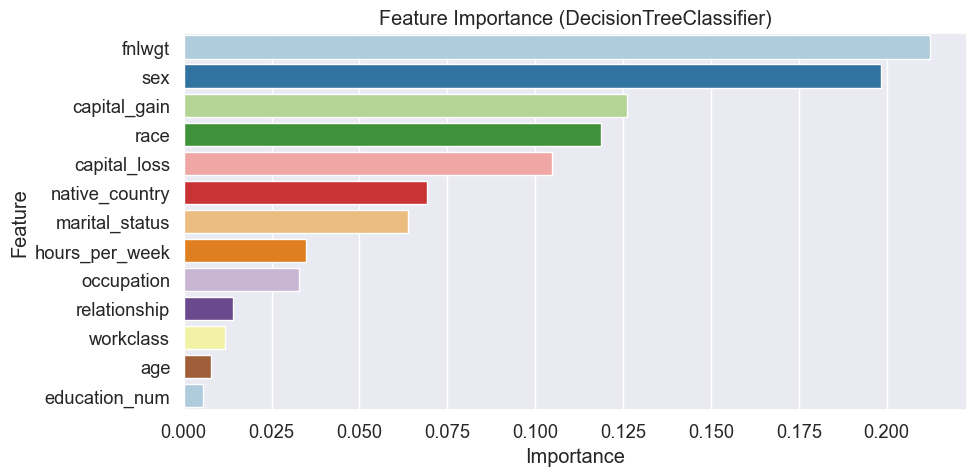

In [39]:
# Obtendo feature importance para DecisionTreeClassifier
model_obj = dt_model.named_steps['model']

# Dataframe de importância de features
importance_df = pd.DataFrame(
    {
        'Feature': X_train.columns,
        'Importance': model_obj.feature_importances_,
    }
).sort_values(by='Importance', ascending=False)

print('-' * 36, importance_df, '-' * 36, sep='\n')

# Plot da importância das features
plt.figure(figsize=(10, 5))
sns.barplot(
    data=importance_df, x='Importance', y='Feature', hue='Feature', palette='Paired'
)
plt.title(f'Feature Importance ({type(model_obj).__name__})')
plt.tight_layout()
plt.show()

------------------------------------
           Feature  Importance
8              sex    0.167599
7             race    0.146616
10    capital_loss    0.106949
2           fnlwgt    0.103714
9     capital_gain    0.103287
4   marital_status    0.099176
3    education_num    0.082447
12  native_country    0.075816
5       occupation    0.035970
11  hours_per_week    0.034582
6     relationship    0.016836
1        workclass    0.014199
0              age    0.012809
------------------------------------


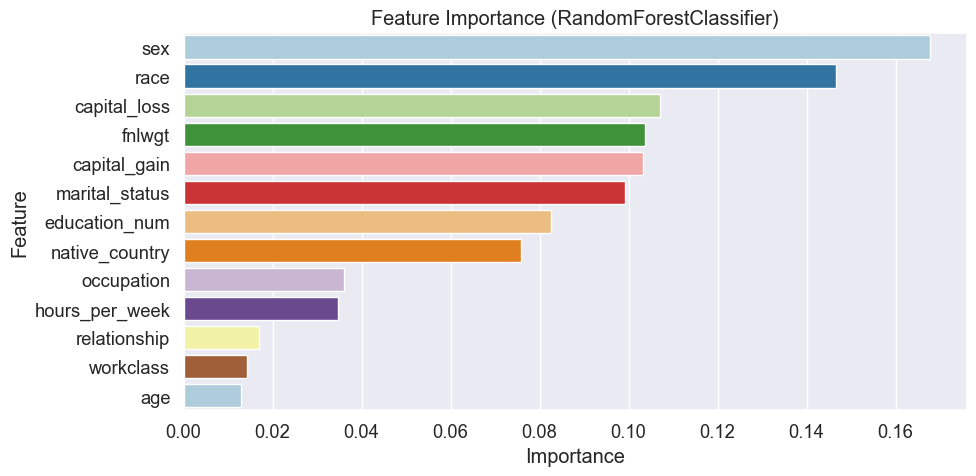

In [40]:
# Obtendo feature importance para DecisionTreeClassifier
model_obj = rf_model.named_steps['model']

importance_df = pd.DataFrame(
    {
        'Feature': X_train.columns,
        'Importance': model_obj.feature_importances_,
    }
).sort_values(by='Importance', ascending=False)

# Dataframe de importância de features
print('-' * 36, importance_df, '-' * 36, sep='\n')

# Plot da importância das features
plt.figure(figsize=(10, 5))
sns.barplot(
    data=importance_df, x='Importance', y='Feature', hue='Feature', palette='Paired'
)
plt.title(f'Feature Importance ({type(model_obj).__name__})')
plt.tight_layout()
plt.show()

## Validação cruzada


### Hold-out

O modelo `DecisionTreeClassifier` tem acurácia de $81\%$, com bom desempenho na classe majoritária (precisão de $0.88$ e recall de $0.87$), mas falha na classe minoritária (precisão e $0.6$ recall de $0.61$).

O modelo `RandomForestRegressor` apresenta acurácia de $86\%$, com menor equilibrio entre as classes, alcançando precisão de $0.73$ e recall de $0.62$ para a classe 0, e $0.89$ e $0.91$ para a classe 1, respectivamente.

O primeiro modelo ($0.182$) tem maior variância nas previsões em comparação ao segundo ($0.16$), indicando que o segundo é mais estável e consistente.


In [41]:
# Avaliando com classification report
print(classification_report(y_test, dt_model_y_preds))

              precision    recall  f1-score   support

           0       0.60      0.61      0.60      1537
           1       0.88      0.87      0.88      4976

    accuracy                           0.81      6513
   macro avg       0.74      0.74      0.74      6513
weighted avg       0.81      0.81      0.81      6513



In [42]:
# Variância do modelo DecisionTree com holdout
np.var(dt_model_y_preds).round(3)

0.182

In [43]:
# Avaliando com classification report
print(classification_report(y_test, rf_model_y_preds))

              precision    recall  f1-score   support

           0       0.73      0.62      0.67      1537
           1       0.89      0.93      0.91      4976

    accuracy                           0.86      6513
   macro avg       0.81      0.77      0.79      6513
weighted avg       0.85      0.86      0.85      6513



In [55]:
# Avaliando com classification report
print(classification_report(y_test, rf_pred_skf_cv))

              precision    recall  f1-score   support

           0       0.73      0.60      0.66      1537
           1       0.88      0.93      0.91      4976

    accuracy                           0.85      6513
   macro avg       0.80      0.76      0.78      6513
weighted avg       0.85      0.85      0.85      6513



In [67]:
# Variância do modelo RandomForestClassifier com holdout
np.var(rf_model_y_preds).round(3)

0.16

### K-fold

O modelo `DecisionTreeClassifier` apresenta acurácia de $80\%$, com desempenho inferior para a classe 0 (precisão de $0.57$ e recall de $0.58$) e, comparação a classe 1 (precisão de $0.87$ e recall de $0.86$). O modelo `RandomForestClassifier` tem acurácia de $85\%$, com um melhor equilibrio entre as classes, alcançando precisão de $0.72$ e recall de $0.60$ para a classe 0, e $0.88$ e $0.93$ para a classe 1, respectivamente.

A variância das previsões do primeiro modelo é $0.183$, enquanto a do segundo modelo é $0.159$. Isso indica que o segundo modelo é mais estável e consistente, apresentando menos variação nas predições, o que sugere maior confiabilidade ao lidar com novos dados.

Os modelos treinados com K-fold apresentaram desempenho ligeiramente inferior ao treinamento com Hold-Out, especialmente na acurácia e no equilibrio entre as classes. Além disso mantiveram variância semelhante, indicando que o uso de K-fold não trouxe ganhos significativos na estabilidade das previsões


In [45]:
# Definindo validação cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=11)

In [46]:
# Obtendo predições com KFold
dt_pred_kf_cv = cross_val_predict(dt_model, X_test, y_test, cv=kf)
rf_pred_kf_cv = cross_val_predict(rf_model, X_test, y_test, cv=kf)

In [47]:
# Avaliando com classification report
print(classification_report(y_test, dt_pred_kf_cv))

              precision    recall  f1-score   support

           0       0.57      0.58      0.57      1537
           1       0.87      0.86      0.87      4976

    accuracy                           0.80      6513
   macro avg       0.72      0.72      0.72      6513
weighted avg       0.80      0.80      0.80      6513



In [68]:
# Variância do modelo DecisionTreeClassifier com KFold
dt_pred_kf_cv.var().round(3)

0.183

In [49]:
# Avaliando com classification report
print(classification_report(y_test, rf_pred_kf_cv))

              precision    recall  f1-score   support

           0       0.72      0.60      0.66      1537
           1       0.88      0.93      0.91      4976

    accuracy                           0.85      6513
   macro avg       0.80      0.77      0.78      6513
weighted avg       0.84      0.85      0.85      6513



In [69]:
# Variância do modelo RandomForestClassifier com KFold
rf_pred_kf_cv.var().round(3)

0.159

### Stratified k-fold

O modelo `DecisionTreeClassifier` teve acurácia foi de 0.80, com a classe 0 apresentando precisão de 0.58 e recall de 0.57, enquanto a classe 1 teve boa performance com precisão e recall de 0.87. O `RandomForestClassifier` apresentou melhor desempenho para a classe 0, com precisão de 0.73 e recall de 0.60, além de manter uma forte performance na classe 1 (precisão de 0.88 e recall de 0.93), resultando em uma acurácia de 0.85.

A variância no `DecisionTreeClassifier` foi de 0.179, indicando uma maior dispersão nas previsões, enquanto no `RandomForestClassifier`, a variância foi ligeiramente menor, 0.156, sugerindo maior consistência nas previsões.

Comparando com o holdout, os modelos utilizando stratified k-fold apresentaram uma acurácia mais baixa (no `RandomForestClassifier` 0.85 vs 0.86 no holdout), o que sugere uma menor performance, mas mais realista em diferentes subconjuntos de dados.


In [51]:
# Definindo validação cruzada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)

In [52]:
# Obtendo predições com KFold
dt_pred_skf_cv = cross_val_predict(dt_model, X_test, y_test, cv=skf)
rf_pred_skf_cv = cross_val_predict(rf_model, X_test, y_test, cv=skf)

In [53]:
# Avaliando com classification report
print(classification_report(y_test, dt_pred_skf_cv))

              precision    recall  f1-score   support

           0       0.58      0.57      0.57      1537
           1       0.87      0.87      0.87      4976

    accuracy                           0.80      6513
   macro avg       0.72      0.72      0.72      6513
weighted avg       0.80      0.80      0.80      6513



In [71]:
# Variância do modelo DecisionTreeClassifier com StratifiedKFold
dt_pred_skf_cv.var().round(3)

0.179

In [76]:
# Avaliando com classification report
print(classification_report(y_test, rf_pred_skf_cv))

              precision    recall  f1-score   support

           0       0.73      0.60      0.66      1537
           1       0.88      0.93      0.91      4976

    accuracy                           0.85      6513
   macro avg       0.80      0.76      0.78      6513
weighted avg       0.85      0.85      0.85      6513



In [70]:
# Variância do modelo RandomForestClassifier com StratifiedKFold
rf_pred_skf_cv.var().round(3)

0.156

## Redução de dimensionalidade

O PCA é uma técnica de redução de dimensionalidade que transforma variáveis correlacionadas em um conjunto menor de variáveis não correlacionadas. Ele captura a maior parte da variabilidade dos dados em menos dimensões, facilitando a visualização e acelerando o algoritmo que usa os dados. Além disso mitiga problemas de multicolinearidade e overfitting em dados complexos de alta dimensionalidade.

### Discutindo performance

Apesar de o PCA ter sido aplicado às features com variância até o quantil $99\%$, a menor quantidade de dados levou o modelo a apresentar um desempenho inferior de maneira geral. Isso provavelmente ocorreu devido ao fato de que o número inicial de features já era baixo, aliado à pequena quantidade de dados disponíveis, o que limitou a eficácia da redução de dimensionalidade promovida pelo PCA.


### Adicionando PCA à Pipeline


#### DecisionTreeClassifier com PCA


In [57]:
# Pipeline PCA DecisionTreeClassifier
dt_pca_model = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('pca', PCA(0.98)),
        ('model', DecisionTreeClassifier(random_state=42)),
    ]
)

In [58]:
# Treinando e avaliando modelo
dt_pca_model.fit(X_train, y_train)

dt_pca_model.score(X_test, y_test)

0.6614463380930447

In [59]:
# Criando predições
dt_pca_model_y_preds = dt_pca_model.predict(X_test)

#### RandomForestClassifier com PCA


In [60]:
# Pipeline PCA RandomForestClassifier
rf_pca_model = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('pca', PCA(0.99)),
        ('model', RandomForestClassifier(random_state=42)),
    ]
)

In [61]:
# Treinando e avaliando modelo
rf_pca_model.fit(X_train, y_train)

rf_pca_model.score(X_test, y_test)

0.6746506986027944

In [62]:
# Criando predições
rf_pca_model_y_preds = rf_pca_model.predict(X_test)

### Avaliação do PCA com `classification_report`


In [63]:
# Obtendo métricas de avaliação para DecisionTree
print(classification_report(y_test, dt_pca_model_y_preds))

              precision    recall  f1-score   support

           0       0.31      0.34      0.32      1537
           1       0.79      0.76      0.77      4976

    accuracy                           0.66      6513
   macro avg       0.55      0.55      0.55      6513
weighted avg       0.67      0.66      0.67      6513



In [64]:
# Obtendo métricas de avaliação para RandomForest
print(classification_report(y_test, rf_pca_model_y_preds))

              precision    recall  f1-score   support

           0       0.30      0.29      0.30      1537
           1       0.78      0.79      0.79      4976

    accuracy                           0.67      6513
   macro avg       0.54      0.54      0.54      6513
weighted avg       0.67      0.67      0.67      6513



## Salvando modelos


In [73]:
# Criando pasta de modelos
!mkdir ../modelos
!mkdir ../modelos/classificacao

mkdir: ../modelos: File exists


In [74]:
# Salvando RandomForestRegressor com RandomSearchCV
pickle.dump(dt_model, open('../modelos/classificacao/dt_model.pkl', 'wb'))

# Salvando XGBRegressor com RandomSearchCV
pickle.dump(rf_model, open('../modelos/classificacao/rf_model.pkl', 'wb'))